In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

warnings.filterwarnings('ignore')


def lstm_sliding_window_prediction(area: str):
    # 1. 創建模擬時間序列數據
    data = pd.read_csv(r"data\owid-covid-data.csv")

    # 選擇某一地區的數據進行分析，例如 "World"
    region_data = data[data['iso_code'] == area]
    region_data['new_cases_smoothed'] = region_data['new_cases_smoothed'].fillna(0)  # 填充缺失值

    # 2. 數據標準化 (z-score)
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(region_data['new_cases_smoothed'].values.reshape(-1, 1))

    # 使用移動窗格創建時間序列數據集
    def create_sliding_window_dataset(data, window_size=10):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, 0])
            y.append(data[i + window_size, 0])
        return np.array(X), np.array(y)

    # 定義窗口大小
    window_size = 28

    # 創建滑動窗口數據集
    X, y = create_sliding_window_dataset(standardized_data, window_size)

    # 重塑 X 為 LSTM 的輸入格式 (樣本數, 時間步長, 特徵數)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # 分割為訓練集和測試集
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 3. 構建 LSTM 模型
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)  # 單一輸出值
    ])

    # 編譯模型
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # 4. 訓練模型
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # 5. 預測並還原預測結果
    predicted_cases = model.predict(X_test)
    predicted_cases = scaler.inverse_transform(predicted_cases)  # 還原標準化

    # 還原測試集實際值
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 6. 視覺化結果
    # plt.figure(figsize=(20, 6))
    # plt.plot(region_data['date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Cases')
    # plt.plot(region_data['date'][-len(predicted_cases):], predicted_cases, color='red', label='Predicted Cases')
    # plt.title('Sliding Window Prediction (New COVID Cases)')
    # plt.xlabel('Date')
    # plt.ylabel('New Cases Smoothed')
    # plt.legend()
    # plt.xticks(rotation=45)
    # plt.show()

    # 7. 評估模型
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    def calculate_mape(true_values, predictions):
        """
        計算 Mean Absolute Percentage Error (MAPE)
        """
        true_values = np.array(true_values)
        predictions = np.array(predictions)
        return np.mean(np.abs((true_values - predictions) / true_values)) * 100

    def calculate_ppe(true_values, predictions):
        """
        計算 Peak Prediction Error (PPE)
        """
        peak_true_value = np.max(true_values)
        peak_true_time = np.argmax(true_values)

        peak_pred_value = np.max(predictions)
        peak_pred_time = np.argmax(predictions)

        value_error = np.abs(peak_true_value - peak_pred_value)
        time_error = np.abs(peak_true_time - peak_pred_time)

        return value_error, time_error

    mae = mean_absolute_error(y_test_actual, predicted_cases)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_cases))
    mape = calculate_mape(y_test_actual, predicted_cases)
    ppe_value_error, ppe_time_error = calculate_ppe(y_test_actual, predicted_cases)

    print(f'MAE: {mae}')
    print(f'MAE / Mean: {mae / np.mean(y_test_actual)}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')
    print(f'Peak Prediction Error (Value): {ppe_value_error}')
    print(f'Peak Prediction Error (Time): {ppe_time_error} days')


In [2]:
data = pd.read_csv(r'data\owid-covid-data.csv')
# 計算 iso_code 的數量，排除以 "OWID" 開頭的代碼
filtered_iso_codes = data["iso_code"].value_counts()
filtered_iso_codes = filtered_iso_codes[~filtered_iso_codes.index.str.startswith("OWID")]

# 取出前 10 至 20 的地區代號並轉換為列表
iso_code_list = filtered_iso_codes.iloc[:30].index.tolist()

# 顯示結果
print(iso_code_list)

['ARG', 'MEX', 'THA', 'TWN', 'CHN', 'MAC', 'KOR', 'JPN', 'USA', 'CAN', 'VNM', 'SGP', 'HKG', 'MYS', 'FRA', 'NPL', 'AUS', 'LKA', 'DEU', 'KHM', 'ARE', 'FIN', 'IND', 'PHL', 'FJI', 'GBR', 'RUS', 'ITA', 'SWE', 'ESP']


In [3]:
regions=["MYS", "ARG", "MEX", "JPN", "CAN", "THA", "VNM", "TWN", "CHN", "SGP"]

# Exclude the region in iso_code_list that is not in the regions list
new_regions = [region for region in iso_code_list if region not in regions] 

In [5]:
for region in new_regions:
    print("=" * 50)
    print(f"Region: {region}")
    
    lstm_sliding_window_prediction(region)

Region: MAC
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
MAE: 0.024021252514863926
MAE / Mean: 0.40013191307380225
RMSE: 0.06736347784375991
MAPE: 24318576140746700.00%
Peak Prediction Error (Value): 0.1214861340522766
Peak Prediction Error (Time): 3 days
Region: KOR
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
MAE: 13012.281381250003
MAE / Mean: 0.5697357150131807
RMSE: 34756.773422966595
MAPE: 24.40%
Peak Prediction Error (Value): 163985.33509374998
Peak Prediction Error (Time): 7 days
Region: USA
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A330D2C160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For 

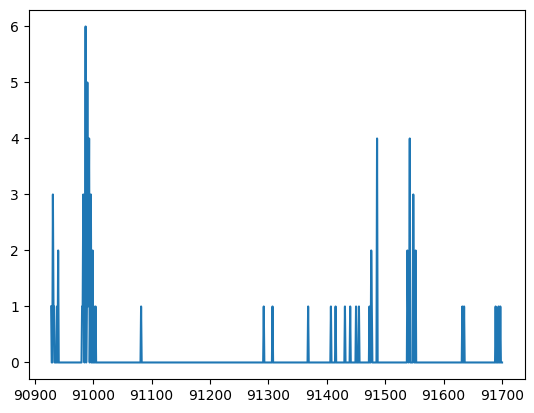

In [49]:
data = pd.read_csv(r"data\owid-covid-data.csv")
region_data = data[data['iso_code'] == "MAC"]
from matplotlib.pyplot import plot
plot(region_data["new_cases"])

In [51]:
region_data["new_cases"].describe()

count    773.000000
mean       0.104787
std        0.504529
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: new_cases, dtype: float64